# Imports

In [174]:
# === Imports ===
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from jcopdl.callback import Callback, set_config
import matplotlib.pyplot as plt
from torchvision.ops.stochastic_depth import stochastic_depth
from torch.amp import GradScaler, autocast

# Setup CUDA if available

In [175]:
# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True if device.type == 'cuda' else False
print(f"Using device:{device}")

Using device:cuda


In [176]:
def seed_everything(seed=42):
    """Set random seed for reproducibility."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
seed_everything()

# Dataset Loader

In [177]:
class BiomedicalDataset(Dataset):
    def __init__(self, df, img_dir, mode, transform_with_horizontal_flip=None, transform_without_horizontal_flip=None, 
                 val_test_transform=None, label_id_to_name=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform_with_horizontal_flip = transform_with_horizontal_flip
        self.transform_without_horizontal_flip = transform_without_horizontal_flip
        self.val_test_transform = val_test_transform
        self.mode = mode
        self.label_id_to_name = label_id_to_name
        self.no_flip_organs = ['kidney-left', 'kidney-right', 'lung-left', 'lung-right', 'femur-left', 'femur-right', 'spleen']

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['id'])
        image = Image.open(img_path).convert('L')  # Grayscale
        image = np.array(image)

        label_id = row.get('class', -1)

        if self.mode == 'train':
            label_name = self.label_id_to_name[label_id]
            if label_name in self.no_flip_organs:
                augmented = self.transform_without_horizontal_flip(image=image)
            else:
                augmented = self.transform_with_horizontal_flip(image=image)          
        elif self.mode in ['val', 'test']:
            augmented = self.val_test_transform(image=image)

        image = augmented['image']

        # Extract view from filename (e.g., 'a_0.png')
        view_char = row['id'][0]
        view_dict = {'a': 0, 'c': 1, 's': 2}
        
        pos_tensor = torch.zeros(3)
        pos_tensor[view_dict[view_char]] = 1

        return image, label_id, pos_tensor, row['id']

# Model Architecture

In [178]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, a=0.01, nonlinearity='leaky_relu')
    elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):  
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, a=0.01, nonlinearity='leaky_relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout2d_prob=0.1, stochastic_depth_prob=0.0):
        super(ResidualBlock, self).__init__()
        self.stochastic_depth_prob = stochastic_depth_prob
        self.shortcut = nn.Sequential()
        self.LeakyReLU = nn.LeakyReLU()
        
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels),
            )

        self.first_conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
            nn.Dropout2d(dropout2d_prob),
        )

        self.final_conv_block = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.first_conv_block(x)
        out = self.final_conv_block(out)
        out = stochastic_depth(out, p=self.stochastic_depth_prob, mode='row', training=self.training)
        out += identity
        out = self.LeakyReLU(out)
        return out

In [ ]:
class ResNet18(nn.Module):
    def __init__(self, num_classes, input_channels=1):
        super(ResNet18, self).__init__()
        self.in_channels = 64

        self.initial_conv = nn.Sequential(
            nn.Conv2d(input_channels, self.in_channels, kernel_size=7, stride=2, padding=3,),
            nn.BatchNorm2d(self.in_channels),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        total_blocks = 14
        min_survival_prob = 0.65  
        max_survival_prob = 0.9  

        survival_probs = np.linspace(max_survival_prob, min_survival_prob, total_blocks)
        drop_probs = 1.0 - survival_probs
        drop_probs = drop_probs.tolist()

        self.layer1 = self._make_layer(64, 3, stride=1,
                                       dropout2d_probs=[0.25] * 3,
                                       stochastic_probs=drop_probs[0:3])

        self.layer2 = self._make_layer(128, 4, stride=2,
                                       dropout2d_probs=[0.3] * 4,
                                       stochastic_probs=drop_probs[3:7])

        self.layer3 = self._make_layer(256, 4, stride=2,
                                       dropout2d_probs=[0.35] * 4,
                                       stochastic_probs=drop_probs[7:11])

        self.layer4 = self._make_layer(512, 3, stride=2,
                                       dropout2d_probs=[0.4] * 3,
                                       stochastic_probs=drop_probs[11:14])

        self.residual_blocks = nn.Sequential(self.layer1, self.layer2, self.layer3, self.layer4)

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Linear(512 + 3, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.35),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.45),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.5),

            nn.Linear(64, num_classes)
        )
        self.apply(initialize_weights)

    def _make_layer(self, out_channels, num_blocks, stride, dropout2d_probs, stochastic_probs):
        layers = []
        for i in range(num_blocks):
            block = ResidualBlock(
                in_channels=self.in_channels,
                out_channels=out_channels,
                stride=stride if i == 0 else 1,
                dropout2d_prob=dropout2d_probs[i],
                stochastic_depth_prob=stochastic_probs[i]
            )
            layers.append(block)
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x, pos_vec):
        out = self.initial_conv(x)
        out = self.residual_blocks(out)
        out = self.global_avg_pool(out)
        out = torch.flatten(out, start_dim=1)
        out = torch.cat((out, pos_vec), dim=1)
        return self.fc(out)

# Data Preparation

## Load Data and Class Labelling

In [181]:
# === Load and Prepare Data ===
df = pd.read_csv('train.csv')
labels = sorted(df['class'].unique())
label_to_idx = {label: i for i, label in enumerate(labels)}
idx_to_label = {i: label for label, i in label_to_idx.items()}

In [182]:
label_to_idx

{'bladder': 0,
 'femur-left': 1,
 'femur-right': 2,
 'heart': 3,
 'kidney-left': 4,
 'kidney-right': 5,
 'liver': 6,
 'lung-left': 7,
 'lung-right': 8,
 'pancreas': 9,
 'spleen': 10}

In [183]:
df['class'] = df['class'].map(label_to_idx)

## Class Distribution

In [184]:
df['class'].value_counts()

6     12614
10     6689
9      6208
4      6183
5      6106
8      5754
7      5662
0      4252
3      2795
1      2639
2      2566
Name: class, dtype: int64

In [185]:
df['class'].value_counts()/df.shape[0] * 100

6     20.521247
10    10.882085
9     10.099564
4     10.058892
5      9.933624
8      9.360968
7      9.211297
0      6.917420
3      4.547081
1      4.293291
2      4.174530
Name: class, dtype: float64

## Train test split

In [186]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=42)

In [187]:
train_df.shape, val_df.shape

((49174, 2), (12294, 2))

## Data Augmentation & Normalization

In [188]:
train_transform_with_h_flip = A.Compose([
    A.RandomResizedCrop(size=(128, 128), scale=(0.7, 1.0), ratio=(0.75, 1.33)),
    A.HorizontalFlip(p=0.5),
    A.Affine(scale=(0.95, 1.05), translate_percent=(-0.05, 0.05), rotate=(-10, 10), p=0.3),
    A.ElasticTransform(alpha=20, sigma=4, p=0.3),

    A.OneOf([
        A.GaussianBlur(blur_limit=(3, 5), sigma_limit=(0.5, 3)),
        A.MotionBlur(blur_limit=5),
    ], p=0.35),

    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),

    A.OneOf([
        A.Emboss(alpha=(0.3, 0.6), strength=(0.2, 0.7)),
        A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0)),
    ], p=0.3),
    
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])


train_transform_no_h_flip = A.Compose([
    A.RandomResizedCrop(size=(128, 128), scale=(0.7, 1.0), ratio=(0.75, 1.33)),
    # NO HorizontalFlip here
    A.Affine(scale=(0.95, 1.05), translate_percent=(-0.05, 0.05), rotate=(-10, 10), p=0.3),
    A.ElasticTransform(alpha=20, sigma=4, p=0.3),

    A.OneOf([
        A.GaussianBlur(blur_limit=(3, 5), sigma_limit=(0.5, 3)),
        A.MotionBlur(blur_limit=5),
    ], p=0.35),

    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),

    A.OneOf([
        A.Emboss(alpha=(0.3, 0.6), strength=(0.2, 0.7)),
        A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0)),
    ], p=0.3),

    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

In [189]:
val_transform = A.Compose([
    A.Resize(128, 128),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

## Data Loader

In [190]:
train_dataset = BiomedicalDataset(df=train_df, img_dir='train', mode='train', transform_with_horizontal_flip=train_transform_with_h_flip, 
                                  transform_without_horizontal_flip=train_transform_no_h_flip, label_id_to_name=idx_to_label)

val_dataset = BiomedicalDataset(df=val_df, img_dir='train', mode='val', val_test_transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

In [191]:
images, labels, feature, ids = next(iter(train_loader))
print(images.shape, labels.shape, feature.shape, ids)

torch.Size([32, 1, 128, 128]) torch.Size([32]) torch.Size([32, 3]) ('s_7138.png', 'a_15176.png', 's_12100.png', 'a_2067.png', 'a_9384.png', 's_11472.png', 's_8030.png', 'c_8856.png', 'c_4034.png', 's_2305.png', 'a_11391.png', 'a_16013.png', 's_8603.png', 'a_13491.png', 'a_19198.png', 'a_2006.png', 'a_28990.png', 'a_21079.png', 's_11624.png', 'a_16262.png', 'a_21892.png', 's_1397.png', 'a_19717.png', 'c_8009.png', 'c_7664.png', 'a_25645.png', 'a_15045.png', 'a_8982.png', 'a_4564.png', 'c_2226.png', 'a_24758.png', 's_10589.png')


# Modelling

## Initialize weights for each classes

In [192]:
class_counts = train_df['class'].value_counts().sort_index()
inv_freq = 1.0 / class_counts.values
weights = (inv_freq / inv_freq.sum()) * len(class_counts)  # Normalize
weights = torch.tensor(weights, dtype=torch.float)
weights

tensor([1.0656, 1.7173, 1.7659, 1.6213, 0.7330, 0.7421, 0.3593, 0.8003, 0.7876,
        0.7300, 0.6775])

## Model Configuration

In [193]:
config = set_config({
    "num_classes": len(label_to_idx),
})

In [194]:
config.num_classes

11

In [195]:
model = ResNet18(num_classes=config.num_classes).to(device)

## Training Setup

In [196]:
model_output_dir = 'model_16th_attempt'

In [197]:
if os.path.exists(model_output_dir) and os.listdir(model_output_dir):
    raise Exception(f"Directory {model_output_dir} already exists and filled. Please choose a different name.")

In [198]:
criterion = nn.CrossEntropyLoss(weight=weights.to(device), label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
callback = Callback(model, config, early_stop_patience=10, plot_every=10, outdir=model_output_dir)
scaler = GradScaler(device=device)

In [199]:
def fn_loop(mode, model, criterion, optimizer, data_loader, scheduler, scaler):
    if mode == 'train':
        model.train()
    elif mode == 'val':
        model.eval()

    running_loss = 0.0
    all_labels = []
    all_preds = []

    for images, labels, features, _ in tqdm(data_loader, desc=mode.title(), total=len(data_loader)):
        images = images.to(device)
        labels = labels.to(device)
        features = features.to(device)

        with autocast(device_type="cuda" if torch.cuda.is_available() else "cpu"):  # Mixed precision forward + loss
            outputs = model(images, features)
            loss = criterion(outputs, labels)

        if mode == 'train':
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        running_loss += loss.item() * images.size(0)
        preds = torch.argmax(outputs, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average='macro')

    if mode == 'val':
        scheduler.step(epoch_loss)
        print(f"\rCurrent Learning Rate: {optimizer.param_groups[0]['lr']}")

    return epoch_loss, epoch_acc, epoch_f1

## Training

Val: 100%|██████████| 49/49 [00:12<00:00,  3.90it/s]


Current Learning Rate: 0.001

Epoch     1
Train_cost  = 2.2280 | Test_cost  = 1.7417 | Train_score = 0.2222 | Test_score = 0.3588 |


Val: 100%|██████████| 49/49 [00:12<00:00,  4.05it/s]


Current Learning Rate: 0.001

Epoch     2
Train_cost  = 1.8790 | Test_cost  = 1.5478 | Train_score = 0.3558 | Test_score = 0.4030 |


Val: 100%|██████████| 49/49 [00:11<00:00,  4.09it/s]


Current Learning Rate: 0.001

Epoch     3
Train_cost  = 1.7123 | Test_cost  = 1.2873 | Train_score = 0.4639 | Test_score = 0.6561 |


Val: 100%|██████████| 49/49 [00:12<00:00,  4.08it/s]


Current Learning Rate: 0.001

Epoch     4
Train_cost  = 1.5608 | Test_cost  = 1.2220 | Train_score = 0.5504 | Test_score = 0.6680 |


Val: 100%|██████████| 49/49 [00:12<00:00,  4.07it/s]


Current Learning Rate: 0.001

Epoch     5
Train_cost  = 1.4524 | Test_cost  = 1.0768 | Train_score = 0.6137 | Test_score = 0.7381 |


Val: 100%|██████████| 49/49 [00:12<00:00,  4.07it/s]


Current Learning Rate: 0.001

Epoch     6
Train_cost  = 1.3704 | Test_cost  = 1.0193 | Train_score = 0.6546 | Test_score = 0.7679 |


Val: 100%|██████████| 49/49 [00:12<00:00,  4.08it/s]


Current Learning Rate: 0.001

Epoch     7
Train_cost  = 1.3071 | Test_cost  = 1.0048 | Train_score = 0.6857 | Test_score = 0.7797 |


Val: 100%|██████████| 49/49 [00:12<00:00,  4.07it/s]


Current Learning Rate: 0.001

Epoch     8
Train_cost  = 1.2595 | Test_cost  = 0.9444 | Train_score = 0.7107 | Test_score = 0.8340 |


Val: 100%|██████████| 49/49 [00:11<00:00,  4.10it/s]


Current Learning Rate: 0.001

Epoch     9
Train_cost  = 1.2145 | Test_cost  = 0.9072 | Train_score = 0.7325 | Test_score = 0.8666 |


Val: 100%|██████████| 49/49 [00:12<00:00,  4.07it/s]

Current Learning Rate: 0.001

Epoch    10
Train_cost  = 1.1768 | Test_cost  = 0.8755 | Train_score = 0.7625 | Test_score = 0.8823 |


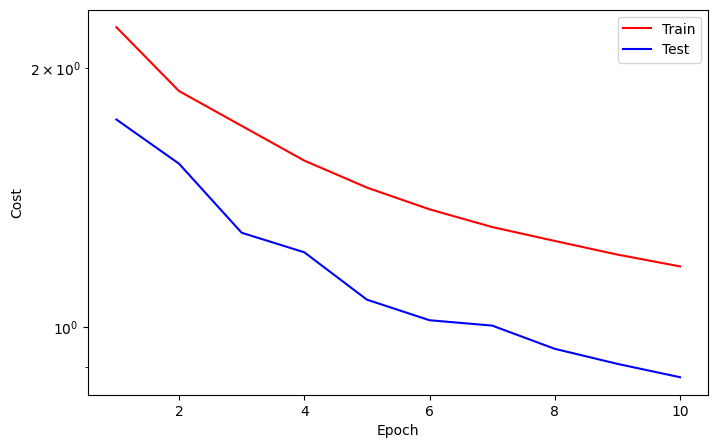

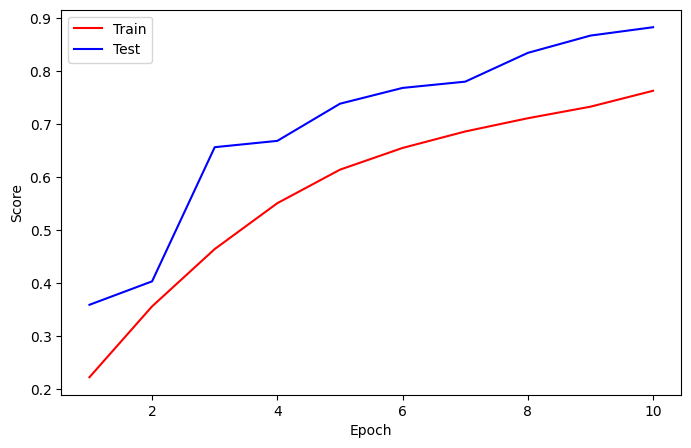

Val: 100%|██████████| 49/49 [00:12<00:00,  4.07it/s]


Current Learning Rate: 0.001

Epoch    11
Train_cost  = 1.1458 | Test_cost  = 0.8576 | Train_score = 0.7809 | Test_score = 0.8902 |


Val: 100%|██████████| 49/49 [00:12<00:00,  4.06it/s]


Current Learning Rate: 0.001

Epoch    12
Train_cost  = 1.1109 | Test_cost  = 0.8391 | Train_score = 0.7969 | Test_score = 0.8975 |


Val: 100%|██████████| 49/49 [00:11<00:00,  4.09it/s]


Current Learning Rate: 0.001

Epoch    13
Train_cost  = 1.0906 | Test_cost  = 0.8074 | Train_score = 0.8079 | Test_score = 0.9038 |


Val: 100%|██████████| 49/49 [00:11<00:00,  4.08it/s]


Current Learning Rate: 0.001

Epoch    14
Train_cost  = 1.0717 | Test_cost  = 0.8003 | Train_score = 0.8193 | Test_score = 0.9082 |


Val: 100%|██████████| 49/49 [00:11<00:00,  4.09it/s]


Current Learning Rate: 0.001

Epoch    15
Train_cost  = 1.0448 | Test_cost  = 0.7848 | Train_score = 0.8311 | Test_score = 0.9158 |


Val: 100%|██████████| 49/49 [00:11<00:00,  4.10it/s]


Current Learning Rate: 0.001

Epoch    16
Train_cost  = 1.0323 | Test_cost  = 0.7692 | Train_score = 0.8360 | Test_score = 0.9220 |


Val: 100%|██████████| 49/49 [00:12<00:00,  4.05it/s]


Current Learning Rate: 0.001

Epoch    17
Train_cost  = 1.0153 | Test_cost  = 0.7655 | Train_score = 0.8435 | Test_score = 0.9233 |


Val: 100%|██████████| 49/49 [00:12<00:00,  4.06it/s]


Current Learning Rate: 0.001

Epoch    18
Train_cost  = 1.0081 | Test_cost  = 0.7605 | Train_score = 0.8478 | Test_score = 0.9240 |


Val: 100%|██████████| 49/49 [00:12<00:00,  4.06it/s]


Current Learning Rate: 0.001

Epoch    19
Train_cost  = 0.9894 | Test_cost  = 0.7615 | Train_score = 0.8542 | Test_score = 0.9303 |
==> EarlyStop patience =  1 | Best test_cost: 0.7605


Val: 100%|██████████| 49/49 [00:12<00:00,  4.07it/s]

Current Learning Rate: 0.001

Epoch    20
Train_cost  = 0.9777 | Test_cost  = 0.7415 | Train_score = 0.8600 | Test_score = 0.9357 |


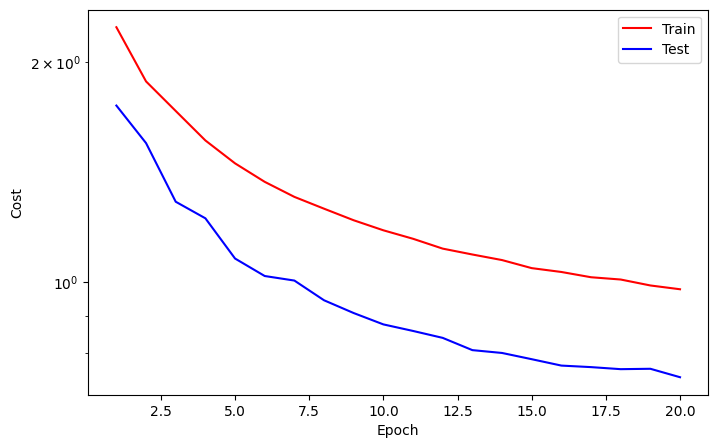

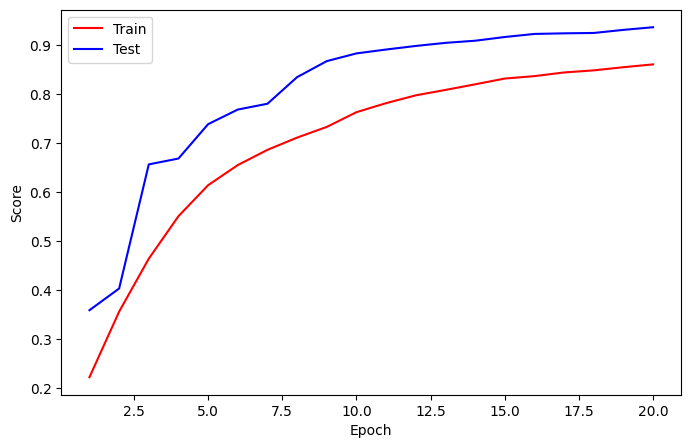

Val: 100%|██████████| 49/49 [00:12<00:00,  4.07it/s]


Current Learning Rate: 0.001

Epoch    21
Train_cost  = 0.9711 | Test_cost  = 0.7346 | Train_score = 0.8627 | Test_score = 0.9403 |


Val: 100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Current Learning Rate: 0.001

Epoch    22
Train_cost  = 0.9608 | Test_cost  = 0.7325 | Train_score = 0.8680 | Test_score = 0.9372 |


Val: 100%|██████████| 49/49 [00:12<00:00,  4.08it/s]


Current Learning Rate: 0.001

Epoch    23
Train_cost  = 0.9549 | Test_cost  = 0.7261 | Train_score = 0.8712 | Test_score = 0.9430 |


Val: 100%|██████████| 49/49 [00:12<00:00,  4.07it/s]


Current Learning Rate: 0.001

Epoch    24
Train_cost  = 0.9412 | Test_cost  = 0.7235 | Train_score = 0.8755 | Test_score = 0.9420 |


Val: 100%|██████████| 49/49 [00:11<00:00,  4.09it/s]


Current Learning Rate: 0.001

Epoch    25
Train_cost  = 0.9325 | Test_cost  = 0.7183 | Train_score = 0.8809 | Test_score = 0.9454 |


Val: 100%|██████████| 49/49 [00:12<00:00,  4.01it/s]


Current Learning Rate: 0.001

Epoch    26
Train_cost  = 0.9285 | Test_cost  = 0.7169 | Train_score = 0.8839 | Test_score = 0.9429 |


Val: 100%|██████████| 49/49 [00:12<00:00,  4.05it/s]


Current Learning Rate: 0.001

Epoch    27
Train_cost  = 0.9207 | Test_cost  = 0.7160 | Train_score = 0.8859 | Test_score = 0.9449 |


Val: 100%|██████████| 49/49 [00:12<00:00,  4.06it/s]


Current Learning Rate: 0.001

Epoch    28
Train_cost  = 0.9154 | Test_cost  = 0.7044 | Train_score = 0.8890 | Test_score = 0.9530 |


Val: 100%|██████████| 49/49 [00:12<00:00,  4.08it/s]


Current Learning Rate: 0.001

Epoch    29
Train_cost  = 0.9044 | Test_cost  = 0.7106 | Train_score = 0.8921 | Test_score = 0.9473 |
==> EarlyStop patience =  1 | Best test_cost: 0.7044


Val: 100%|██████████| 49/49 [00:12<00:00,  3.96it/s]

Current Learning Rate: 0.001

Epoch    30
Train_cost  = 0.9017 | Test_cost  = 0.6983 | Train_score = 0.8929 | Test_score = 0.9534 |


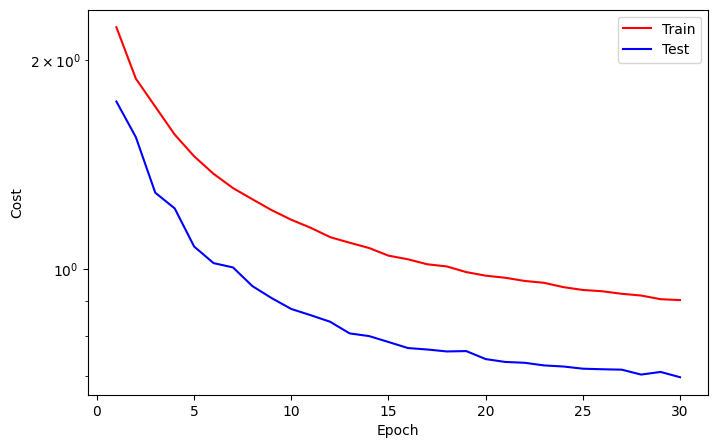

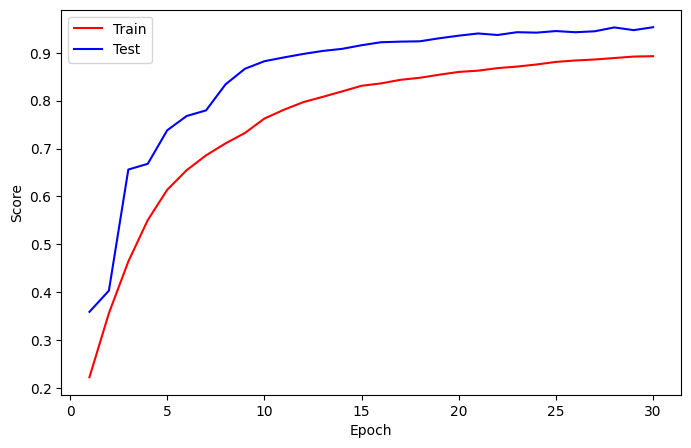

Val: 100%|██████████| 49/49 [00:11<00:00,  4.09it/s]


Current Learning Rate: 0.001

Epoch    31
Train_cost  = 0.8959 | Test_cost  = 0.6983 | Train_score = 0.8966 | Test_score = 0.9514 |
==> EarlyStop patience =  1 | Best test_cost: 0.6983


Val: 100%|██████████| 49/49 [00:12<00:00,  4.06it/s]


Current Learning Rate: 0.001

Epoch    32
Train_cost  = 0.8980 | Test_cost  = 0.6933 | Train_score = 0.8984 | Test_score = 0.9545 |


Val: 100%|██████████| 49/49 [00:12<00:00,  4.06it/s]


Current Learning Rate: 0.001

Epoch    33
Train_cost  = 0.8888 | Test_cost  = 0.6963 | Train_score = 0.8987 | Test_score = 0.9563 |
==> EarlyStop patience =  1 | Best test_cost: 0.6933


Val: 100%|██████████| 49/49 [00:12<00:00,  4.08it/s]


Current Learning Rate: 0.001

Epoch    34
Train_cost  = 0.8818 | Test_cost  = 0.6908 | Train_score = 0.9037 | Test_score = 0.9546 |


Val: 100%|██████████| 49/49 [00:11<00:00,  4.10it/s]


Current Learning Rate: 0.001

Epoch    35
Train_cost  = 0.8809 | Test_cost  = 0.6941 | Train_score = 0.9028 | Test_score = 0.9544 |
==> EarlyStop patience =  1 | Best test_cost: 0.6908


Val: 100%|██████████| 49/49 [00:12<00:00,  4.06it/s]


Current Learning Rate: 0.001

Epoch    36
Train_cost  = 0.8713 | Test_cost  = 0.7033 | Train_score = 0.9077 | Test_score = 0.9501 |
==> EarlyStop patience =  2 | Best test_cost: 0.6908


Val: 100%|██████████| 49/49 [00:11<00:00,  4.10it/s]


Current Learning Rate: 0.001

Epoch    37
Train_cost  = 0.8728 | Test_cost  = 0.6839 | Train_score = 0.9086 | Test_score = 0.9588 |


Val: 100%|██████████| 49/49 [00:11<00:00,  4.09it/s]


Current Learning Rate: 0.001

Epoch    38
Train_cost  = 0.8674 | Test_cost  = 0.6913 | Train_score = 0.9109 | Test_score = 0.9532 |
==> EarlyStop patience =  1 | Best test_cost: 0.6839


Val: 100%|██████████| 49/49 [00:11<00:00,  4.09it/s]


Current Learning Rate: 0.001

Epoch    39
Train_cost  = 0.8640 | Test_cost  = 0.6858 | Train_score = 0.9118 | Test_score = 0.9576 |
==> EarlyStop patience =  2 | Best test_cost: 0.6839


Val: 100%|██████████| 49/49 [00:11<00:00,  4.09it/s]

Current Learning Rate: 0.001

Epoch    40
Train_cost  = 0.8667 | Test_cost  = 0.6813 | Train_score = 0.9101 | Test_score = 0.9620 |


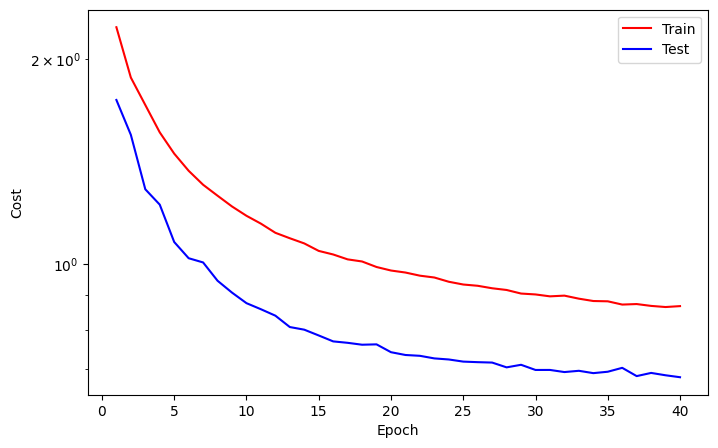

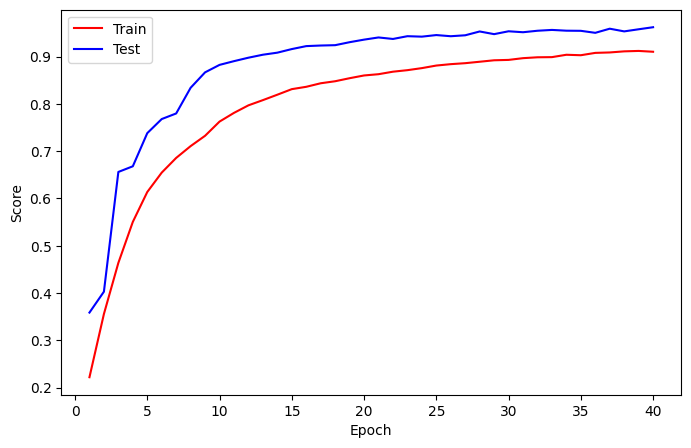

Val: 100%|██████████| 49/49 [00:12<00:00,  4.08it/s]


Current Learning Rate: 0.001

Epoch    41
Train_cost  = 0.8574 | Test_cost  = 0.6846 | Train_score = 0.9147 | Test_score = 0.9588 |
==> EarlyStop patience =  1 | Best test_cost: 0.6813


Val: 100%|██████████| 49/49 [00:12<00:00,  4.08it/s]


Current Learning Rate: 0.001

Epoch    42
Train_cost  = 0.8533 | Test_cost  = 0.6842 | Train_score = 0.9163 | Test_score = 0.9580 |
==> EarlyStop patience =  2 | Best test_cost: 0.6813


Val: 100%|██████████| 49/49 [00:12<00:00,  4.06it/s]


Current Learning Rate: 0.001

Epoch    43
Train_cost  = 0.8515 | Test_cost  = 0.6764 | Train_score = 0.9167 | Test_score = 0.9618 |


Val: 100%|██████████| 49/49 [00:12<00:00,  4.08it/s]


Current Learning Rate: 0.001

Epoch    44
Train_cost  = 0.8513 | Test_cost  = 0.6796 | Train_score = 0.9186 | Test_score = 0.9580 |
==> EarlyStop patience =  1 | Best test_cost: 0.6764


Val: 100%|██████████| 49/49 [00:12<00:00,  4.06it/s]


Current Learning Rate: 0.001

Epoch    45
Train_cost  = 0.8497 | Test_cost  = 0.6771 | Train_score = 0.9163 | Test_score = 0.9631 |
==> EarlyStop patience =  2 | Best test_cost: 0.6764


Val: 100%|██████████| 49/49 [00:12<00:00,  4.08it/s]


Current Learning Rate: 0.001

Epoch    46
Train_cost  = 0.8482 | Test_cost  = 0.6791 | Train_score = 0.9182 | Test_score = 0.9582 |
==> EarlyStop patience =  3 | Best test_cost: 0.6764


Val: 100%|██████████| 49/49 [00:12<00:00,  4.07it/s]


Current Learning Rate: 0.001

Epoch    47
Train_cost  = 0.8394 | Test_cost  = 0.6733 | Train_score = 0.9222 | Test_score = 0.9644 |


Val: 100%|██████████| 49/49 [00:12<00:00,  4.05it/s]


Current Learning Rate: 0.001

Epoch    48
Train_cost  = 0.8438 | Test_cost  = 0.6709 | Train_score = 0.9220 | Test_score = 0.9631 |


Val: 100%|██████████| 49/49 [00:12<00:00,  4.07it/s]


Current Learning Rate: 0.001

Epoch    49
Train_cost  = 0.8404 | Test_cost  = 0.6686 | Train_score = 0.9209 | Test_score = 0.9660 |


Val: 100%|██████████| 49/49 [00:12<00:00,  4.07it/s]


Current Learning Rate: 0.001

Epoch    50
Train_cost  = 0.8356 | Test_cost  = 0.6764 | Train_score = 0.9251 | Test_score = 0.9623 |


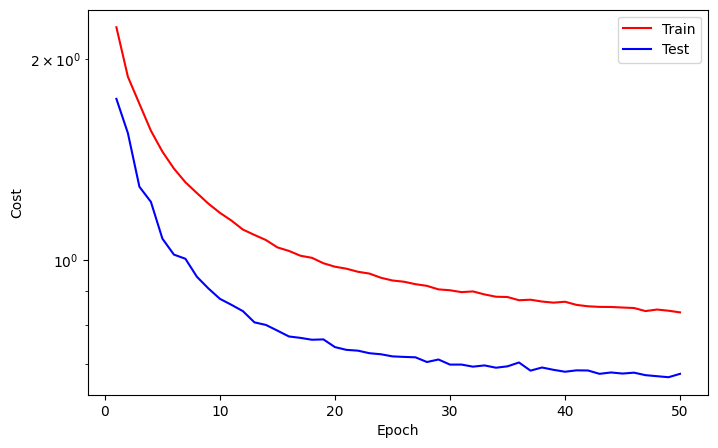

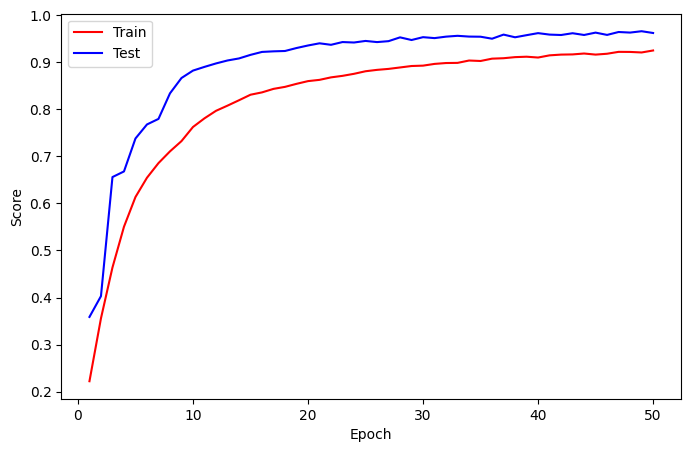

==> EarlyStop patience =  1 | Best test_cost: 0.6686


Val: 100%|██████████| 49/49 [00:11<00:00,  4.08it/s]


Current Learning Rate: 0.001

Epoch    51
Train_cost  = 0.8344 | Test_cost  = 0.6734 | Train_score = 0.9244 | Test_score = 0.9626 |
==> EarlyStop patience =  2 | Best test_cost: 0.6686


Val: 100%|██████████| 49/49 [00:11<00:00,  4.10it/s]


Current Learning Rate: 0.001

Epoch    52
Train_cost  = 0.8356 | Test_cost  = 0.6708 | Train_score = 0.9251 | Test_score = 0.9621 |
==> EarlyStop patience =  3 | Best test_cost: 0.6686


Val: 100%|██████████| 49/49 [00:11<00:00,  4.08it/s]


Current Learning Rate: 0.0005

Epoch    53
Train_cost  = 0.8319 | Test_cost  = 0.6755 | Train_score = 0.9239 | Test_score = 0.9623 |
==> EarlyStop patience =  4 | Best test_cost: 0.6686


Val: 100%|██████████| 49/49 [00:12<00:00,  3.98it/s]


Current Learning Rate: 0.0005

Epoch    54
Train_cost  = 0.8064 | Test_cost  = 0.6659 | Train_score = 0.9358 | Test_score = 0.9695 |


Val: 100%|██████████| 49/49 [00:12<00:00,  4.08it/s]


Current Learning Rate: 0.0005

Epoch    55
Train_cost  = 0.7980 | Test_cost  = 0.6629 | Train_score = 0.9396 | Test_score = 0.9676 |


Val: 100%|██████████| 49/49 [00:11<00:00,  4.10it/s]


Current Learning Rate: 0.0005

Epoch    56
Train_cost  = 0.7959 | Test_cost  = 0.6614 | Train_score = 0.9411 | Test_score = 0.9662 |


Val: 100%|██████████| 49/49 [00:12<00:00,  4.06it/s]


Current Learning Rate: 0.0005

Epoch    57
Train_cost  = 0.7891 | Test_cost  = 0.6621 | Train_score = 0.9420 | Test_score = 0.9715 |
==> EarlyStop patience =  1 | Best test_cost: 0.6614


Val: 100%|██████████| 49/49 [00:11<00:00,  4.09it/s]


Current Learning Rate: 0.0005

Epoch    58
Train_cost  = 0.7871 | Test_cost  = 0.6564 | Train_score = 0.9450 | Test_score = 0.9678 |


Val: 100%|██████████| 49/49 [00:11<00:00,  4.10it/s]


Current Learning Rate: 0.0005

Epoch    59
Train_cost  = 0.7870 | Test_cost  = 0.6575 | Train_score = 0.9448 | Test_score = 0.9686 |
==> EarlyStop patience =  1 | Best test_cost: 0.6564


Val: 100%|██████████| 49/49 [00:12<00:00,  3.96it/s]

Current Learning Rate: 0.0005

Epoch    60
Train_cost  = 0.7843 | Test_cost  = 0.6565 | Train_score = 0.9475 | Test_score = 0.9692 |


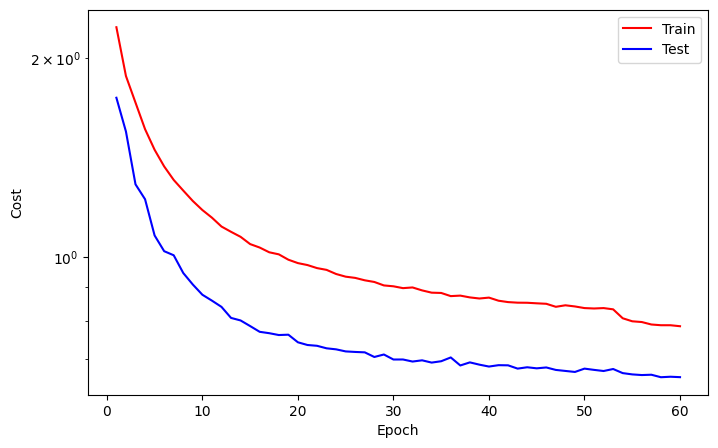

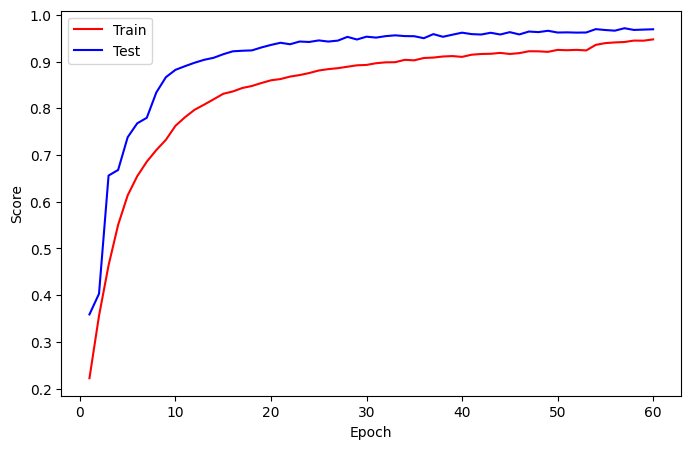

==> EarlyStop patience =  2 | Best test_cost: 0.6564


Val: 100%|██████████| 49/49 [00:12<00:00,  4.06it/s]


Current Learning Rate: 0.0005

Epoch    61
Train_cost  = 0.7822 | Test_cost  = 0.6596 | Train_score = 0.9469 | Test_score = 0.9702 |
==> EarlyStop patience =  3 | Best test_cost: 0.6564


Val: 100%|██████████| 49/49 [00:11<00:00,  4.08it/s]


Current Learning Rate: 0.00025

Epoch    62
Train_cost  = 0.7763 | Test_cost  = 0.6587 | Train_score = 0.9510 | Test_score = 0.9691 |
==> EarlyStop patience =  4 | Best test_cost: 0.6564


Val: 100%|██████████| 49/49 [00:12<00:00,  4.08it/s]


Current Learning Rate: 0.00025

Epoch    63
Train_cost  = 0.7690 | Test_cost  = 0.6512 | Train_score = 0.9527 | Test_score = 0.9714 |


Val: 100%|██████████| 49/49 [00:11<00:00,  4.09it/s]


Current Learning Rate: 0.00025

Epoch    64
Train_cost  = 0.7658 | Test_cost  = 0.6514 | Train_score = 0.9544 | Test_score = 0.9740 |
==> EarlyStop patience =  1 | Best test_cost: 0.6512


Val: 100%|██████████| 49/49 [00:12<00:00,  4.08it/s]


Current Learning Rate: 0.00025

Epoch    65
Train_cost  = 0.7602 | Test_cost  = 0.6530 | Train_score = 0.9571 | Test_score = 0.9720 |
==> EarlyStop patience =  2 | Best test_cost: 0.6512


Val: 100%|██████████| 49/49 [00:12<00:00,  4.05it/s]


Current Learning Rate: 0.00025

Epoch    66
Train_cost  = 0.7611 | Test_cost  = 0.6498 | Train_score = 0.9572 | Test_score = 0.9741 |


Val: 100%|██████████| 49/49 [00:12<00:00,  4.05it/s]


Current Learning Rate: 0.00025

Epoch    67
Train_cost  = 0.7594 | Test_cost  = 0.6507 | Train_score = 0.9585 | Test_score = 0.9729 |
==> EarlyStop patience =  1 | Best test_cost: 0.6498


Val: 100%|██████████| 49/49 [00:12<00:00,  4.07it/s]


Current Learning Rate: 0.00025

Epoch    68
Train_cost  = 0.7533 | Test_cost  = 0.6491 | Train_score = 0.9605 | Test_score = 0.9723 |


Val: 100%|██████████| 49/49 [00:11<00:00,  4.09it/s]


Current Learning Rate: 0.00025

Epoch    69
Train_cost  = 0.7574 | Test_cost  = 0.6487 | Train_score = 0.9586 | Test_score = 0.9734 |


Val: 100%|██████████| 49/49 [00:12<00:00,  4.08it/s]

Current Learning Rate: 0.00025

Epoch    70
Train_cost  = 0.7564 | Test_cost  = 0.6504 | Train_score = 0.9583 | Test_score = 0.9740 |


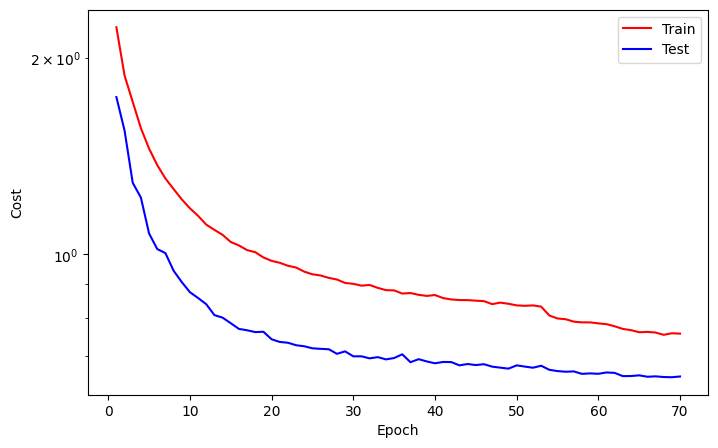

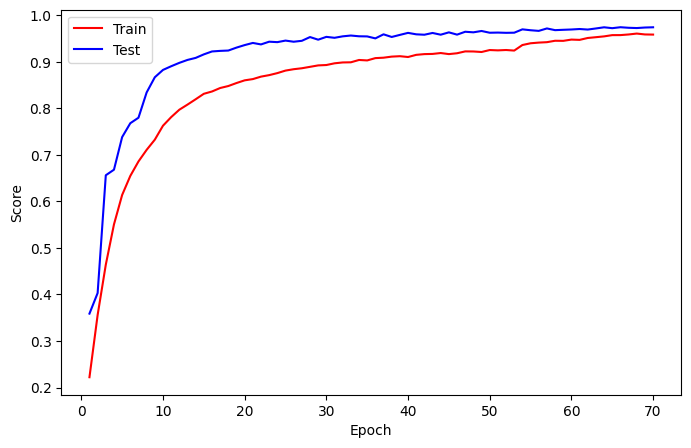

==> EarlyStop patience =  1 | Best test_cost: 0.6487


Val: 100%|██████████| 49/49 [00:12<00:00,  4.07it/s]


Current Learning Rate: 0.00025

Epoch    71
Train_cost  = 0.7522 | Test_cost  = 0.6524 | Train_score = 0.9602 | Test_score = 0.9711 |
==> EarlyStop patience =  2 | Best test_cost: 0.6487


Val: 100%|██████████| 49/49 [00:12<00:00,  4.06it/s]


Current Learning Rate: 0.00025

Epoch    72
Train_cost  = 0.7542 | Test_cost  = 0.6482 | Train_score = 0.9606 | Test_score = 0.9706 |


Val: 100%|██████████| 49/49 [00:11<00:00,  4.09it/s]


Current Learning Rate: 0.00025

Epoch    73
Train_cost  = 0.7525 | Test_cost  = 0.6501 | Train_score = 0.9617 | Test_score = 0.9724 |
==> EarlyStop patience =  1 | Best test_cost: 0.6482


Val: 100%|██████████| 49/49 [00:12<00:00,  4.04it/s]


Current Learning Rate: 0.00025

Epoch    74
Train_cost  = 0.7536 | Test_cost  = 0.6473 | Train_score = 0.9610 | Test_score = 0.9731 |


Val: 100%|██████████| 49/49 [00:12<00:00,  4.07it/s]


Current Learning Rate: 0.00025

Epoch    75
Train_cost  = 0.7515 | Test_cost  = 0.6508 | Train_score = 0.9610 | Test_score = 0.9746 |
==> EarlyStop patience =  1 | Best test_cost: 0.6473


Val: 100%|██████████| 49/49 [00:11<00:00,  4.10it/s]


Current Learning Rate: 0.00025

Epoch    76
Train_cost  = 0.7472 | Test_cost  = 0.6481 | Train_score = 0.9636 | Test_score = 0.9728 |
==> EarlyStop patience =  2 | Best test_cost: 0.6473


Val: 100%|██████████| 49/49 [00:12<00:00,  4.08it/s]


Current Learning Rate: 0.00025

Epoch    77
Train_cost  = 0.7483 | Test_cost  = 0.6486 | Train_score = 0.9635 | Test_score = 0.9727 |
==> EarlyStop patience =  3 | Best test_cost: 0.6473


Val: 100%|██████████| 49/49 [00:11<00:00,  4.09it/s]


Current Learning Rate: 0.000125

Epoch    78
Train_cost  = 0.7480 | Test_cost  = 0.6494 | Train_score = 0.9636 | Test_score = 0.9755 |
==> EarlyStop patience =  4 | Best test_cost: 0.6473


Val: 100%|██████████| 49/49 [00:12<00:00,  4.07it/s]


Current Learning Rate: 0.000125

Epoch    79
Train_cost  = 0.7435 | Test_cost  = 0.6481 | Train_score = 0.9659 | Test_score = 0.9729 |
==> EarlyStop patience =  5 | Best test_cost: 0.6473


Val: 100%|██████████| 49/49 [00:12<00:00,  4.04it/s]

Current Learning Rate: 0.000125

Epoch    80
Train_cost  = 0.7413 | Test_cost  = 0.6493 | Train_score = 0.9667 | Test_score = 0.9739 |


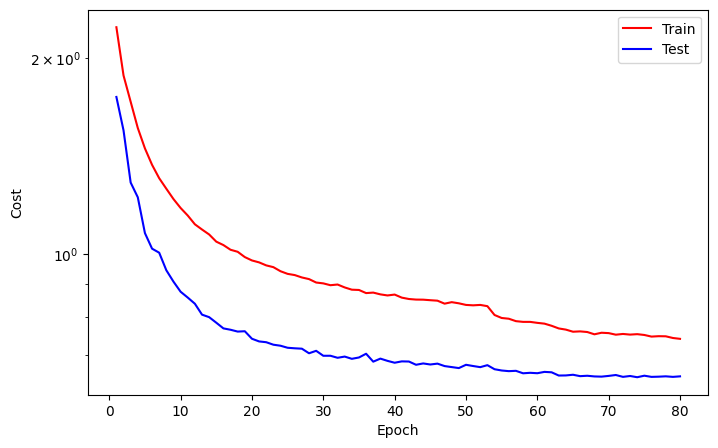

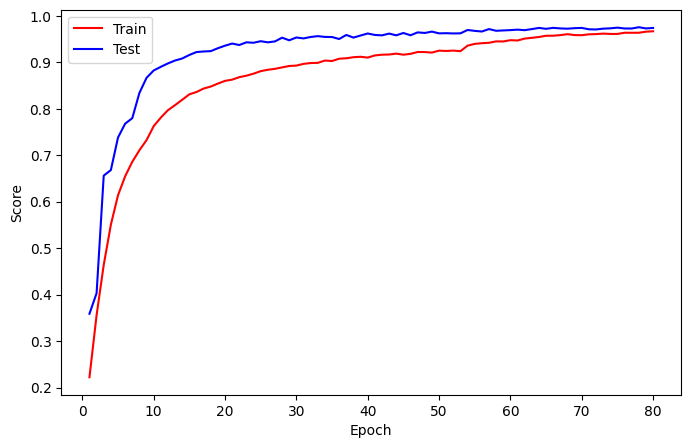

==> EarlyStop patience =  6 | Best test_cost: 0.6473


Val: 100%|██████████| 49/49 [00:11<00:00,  4.09it/s]


Current Learning Rate: 0.000125

Epoch    81
Train_cost  = 0.7413 | Test_cost  = 0.6475 | Train_score = 0.9667 | Test_score = 0.9736 |
==> EarlyStop patience =  7 | Best test_cost: 0.6473


Val: 100%|██████████| 49/49 [00:12<00:00,  4.07it/s]


Current Learning Rate: 0.000125

Epoch    82
Train_cost  = 0.7381 | Test_cost  = 0.6467 | Train_score = 0.9687 | Test_score = 0.9735 |


Val: 100%|██████████| 49/49 [00:12<00:00,  4.01it/s]


Current Learning Rate: 0.000125

Epoch    83
Train_cost  = 0.7391 | Test_cost  = 0.6468 | Train_score = 0.9676 | Test_score = 0.9739 |
==> EarlyStop patience =  1 | Best test_cost: 0.6467


Val: 100%|██████████| 49/49 [00:12<00:00,  4.08it/s]


Current Learning Rate: 0.000125

Epoch    84
Train_cost  = 0.7389 | Test_cost  = 0.6452 | Train_score = 0.9677 | Test_score = 0.9737 |


Val: 100%|██████████| 49/49 [00:12<00:00,  4.06it/s]


Current Learning Rate: 0.000125

Epoch    85
Train_cost  = 0.7380 | Test_cost  = 0.6481 | Train_score = 0.9680 | Test_score = 0.9740 |
==> EarlyStop patience =  1 | Best test_cost: 0.6452


Val: 100%|██████████| 49/49 [00:12<00:00,  4.06it/s]


Current Learning Rate: 0.000125

Epoch    86
Train_cost  = 0.7358 | Test_cost  = 0.6455 | Train_score = 0.9685 | Test_score = 0.9762 |
==> EarlyStop patience =  2 | Best test_cost: 0.6452


Val: 100%|██████████| 49/49 [00:11<00:00,  4.09it/s]


Current Learning Rate: 0.000125

Epoch    87
Train_cost  = 0.7372 | Test_cost  = 0.6466 | Train_score = 0.9689 | Test_score = 0.9740 |
==> EarlyStop patience =  3 | Best test_cost: 0.6452


Val: 100%|██████████| 49/49 [00:12<00:00,  4.08it/s]


Current Learning Rate: 6.25e-05

Epoch    88
Train_cost  = 0.7347 | Test_cost  = 0.6477 | Train_score = 0.9704 | Test_score = 0.9744 |
==> EarlyStop patience =  4 | Best test_cost: 0.6452


Val: 100%|██████████| 49/49 [00:12<00:00,  4.08it/s]


Current Learning Rate: 6.25e-05

Epoch    89
Train_cost  = 0.7331 | Test_cost  = 0.6489 | Train_score = 0.9709 | Test_score = 0.9738 |
==> EarlyStop patience =  5 | Best test_cost: 0.6452


Val: 100%|██████████| 49/49 [00:12<00:00,  3.96it/s]

Current Learning Rate: 6.25e-05

Epoch    90
Train_cost  = 0.7340 | Test_cost  = 0.6474 | Train_score = 0.9702 | Test_score = 0.9741 |


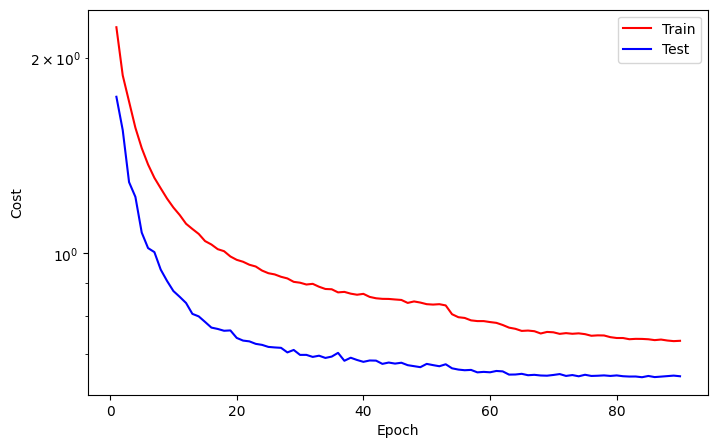

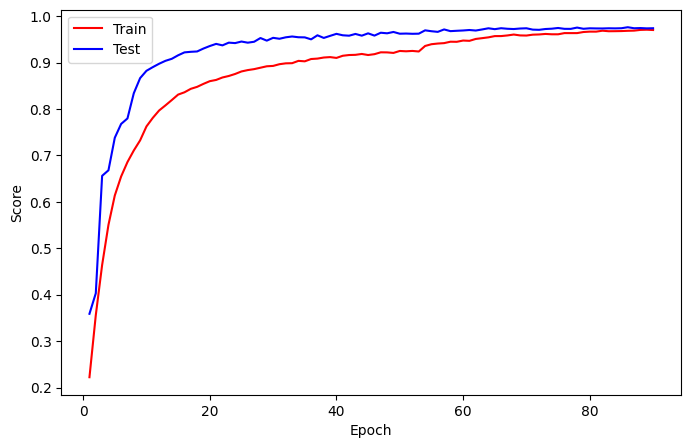

==> EarlyStop patience =  6 | Best test_cost: 0.6452


Val: 100%|██████████| 49/49 [00:12<00:00,  4.05it/s]


Current Learning Rate: 6.25e-05

Epoch    91
Train_cost  = 0.7341 | Test_cost  = 0.6476 | Train_score = 0.9710 | Test_score = 0.9744 |
==> EarlyStop patience =  7 | Best test_cost: 0.6452


Val: 100%|██████████| 49/49 [00:12<00:00,  4.05it/s]


Current Learning Rate: 3.125e-05

Epoch    92
Train_cost  = 0.7325 | Test_cost  = 0.6453 | Train_score = 0.9696 | Test_score = 0.9747 |
==> EarlyStop patience =  8 | Best test_cost: 0.6452


Val: 100%|██████████| 49/49 [00:12<00:00,  4.07it/s]


Current Learning Rate: 3.125e-05

Epoch    93
Train_cost  = 0.7312 | Test_cost  = 0.6457 | Train_score = 0.9718 | Test_score = 0.9739 |
==> EarlyStop patience =  9 | Best test_cost: 0.6452


Val: 100%|██████████| 49/49 [00:12<00:00,  4.06it/s]


Current Learning Rate: 3.125e-05

Epoch    94
Train_cost  = 0.7285 | Test_cost  = 0.6466 | Train_score = 0.9731 | Test_score = 0.9747 |
==> EarlyStop patience = 10 | Best test_cost: 0.6452
==> Execute Early Stopping at epoch: 94 | Best test_cost: 0.6452
==> Best model is saved at model_16th_attempt


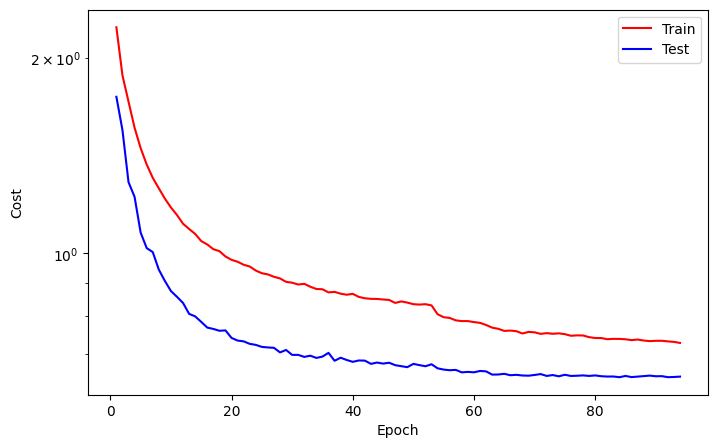

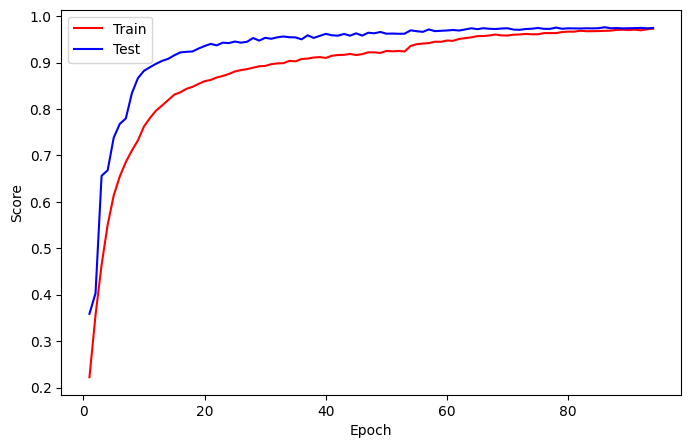

In [200]:
while True:
    train_loss, train_acc, train_f1 = fn_loop('train', model, criterion, optimizer, train_loader, scheduler, scaler=scaler)
    with torch.no_grad():
        val_loss, val_acc, val_f1 = fn_loop('val', model, criterion, optimizer, val_loader, scheduler, scaler=scaler)
    
    # logging
    callback.log(train_cost=train_loss, test_cost=val_loss, train_score=train_f1, test_score=val_f1)
    
    # save checkpoint
    callback.save_checkpoint()

    # plot cost and score
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()

    # early stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        callback.plot_score()
        break

# Evaluation

## Cost and Score History Plot

In [201]:
logs = torch.load(f'{model_output_dir}/logs.pth', map_location=device)

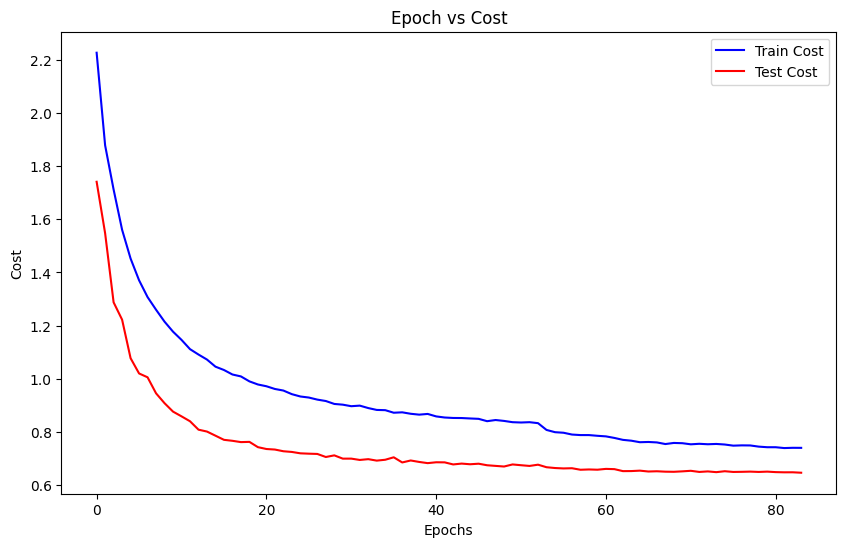

In [202]:
plt.figure(figsize=(10, 6))
plt.plot(logs['train_cost'], label='Train Cost', color='blue')
plt.plot(logs['test_cost'], label='Test Cost', color='red')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.title('Epoch vs Cost')
plt.savefig(f'{model_output_dir}/epoch_vs_cost.png')
plt.legend()
plt.show()

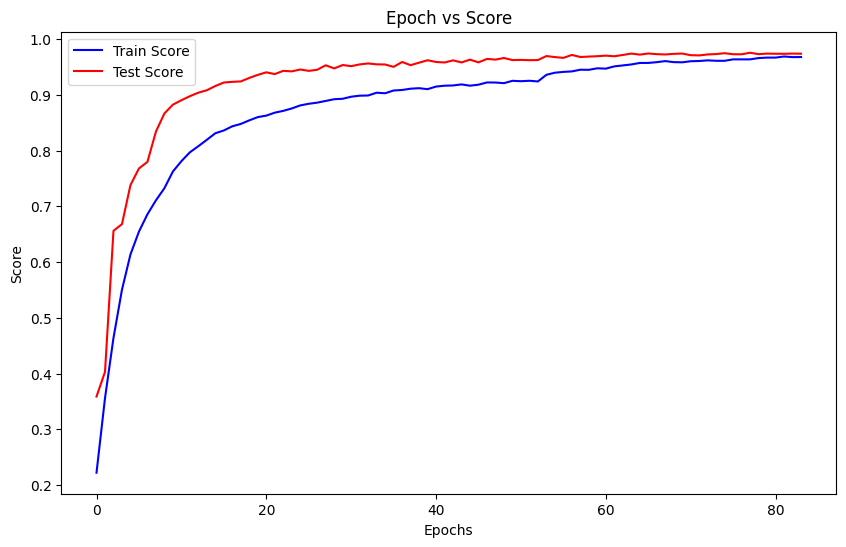

In [203]:
plt.figure(figsize=(10, 6))
plt.plot(logs['train_score'], label='Train Score', color='blue')
plt.plot(logs['test_score'], label='Test Score', color='red')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Epoch vs Score')
plt.savefig(f'{model_output_dir}/epoch_vs_score.png')
plt.legend()
plt.show()

## Evaluation Score

In [204]:
# === Evaluation ===
model.eval()
val_preds, val_labels = [], []
with torch.no_grad():
    for images, labels, features, _ in tqdm(val_loader, desc="Evaluating"):
        images, labels, features = images.to(device), labels.to(device), features.to(device)
        with autocast(device_type="cuda" if torch.cuda.is_available() else "cpu"):
            outputs = model(images, features)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        val_preds.extend(preds)
        val_labels.extend(labels.cpu().numpy())

Evaluating: 100%|██████████| 49/49 [00:12<00:00,  3.99it/s]


In [205]:
acc = accuracy_score(val_labels, val_preds)
f1 = f1_score(val_labels, val_preds, average='weighted')
print(f"Validation Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")

Validation Accuracy: 0.9839, F1 Score: 0.9839


In [206]:
with open(f'{model_output_dir}/evaluation.txt', 'w') as f:
    print(f"Validation Accuracy: {acc:.4f}, Validation F1 Score: {f1:.4f}", file=f)

## Check Image Prediction

In [207]:
val_iter = iter(val_loader)
images, labels, _, _ = next(val_iter)

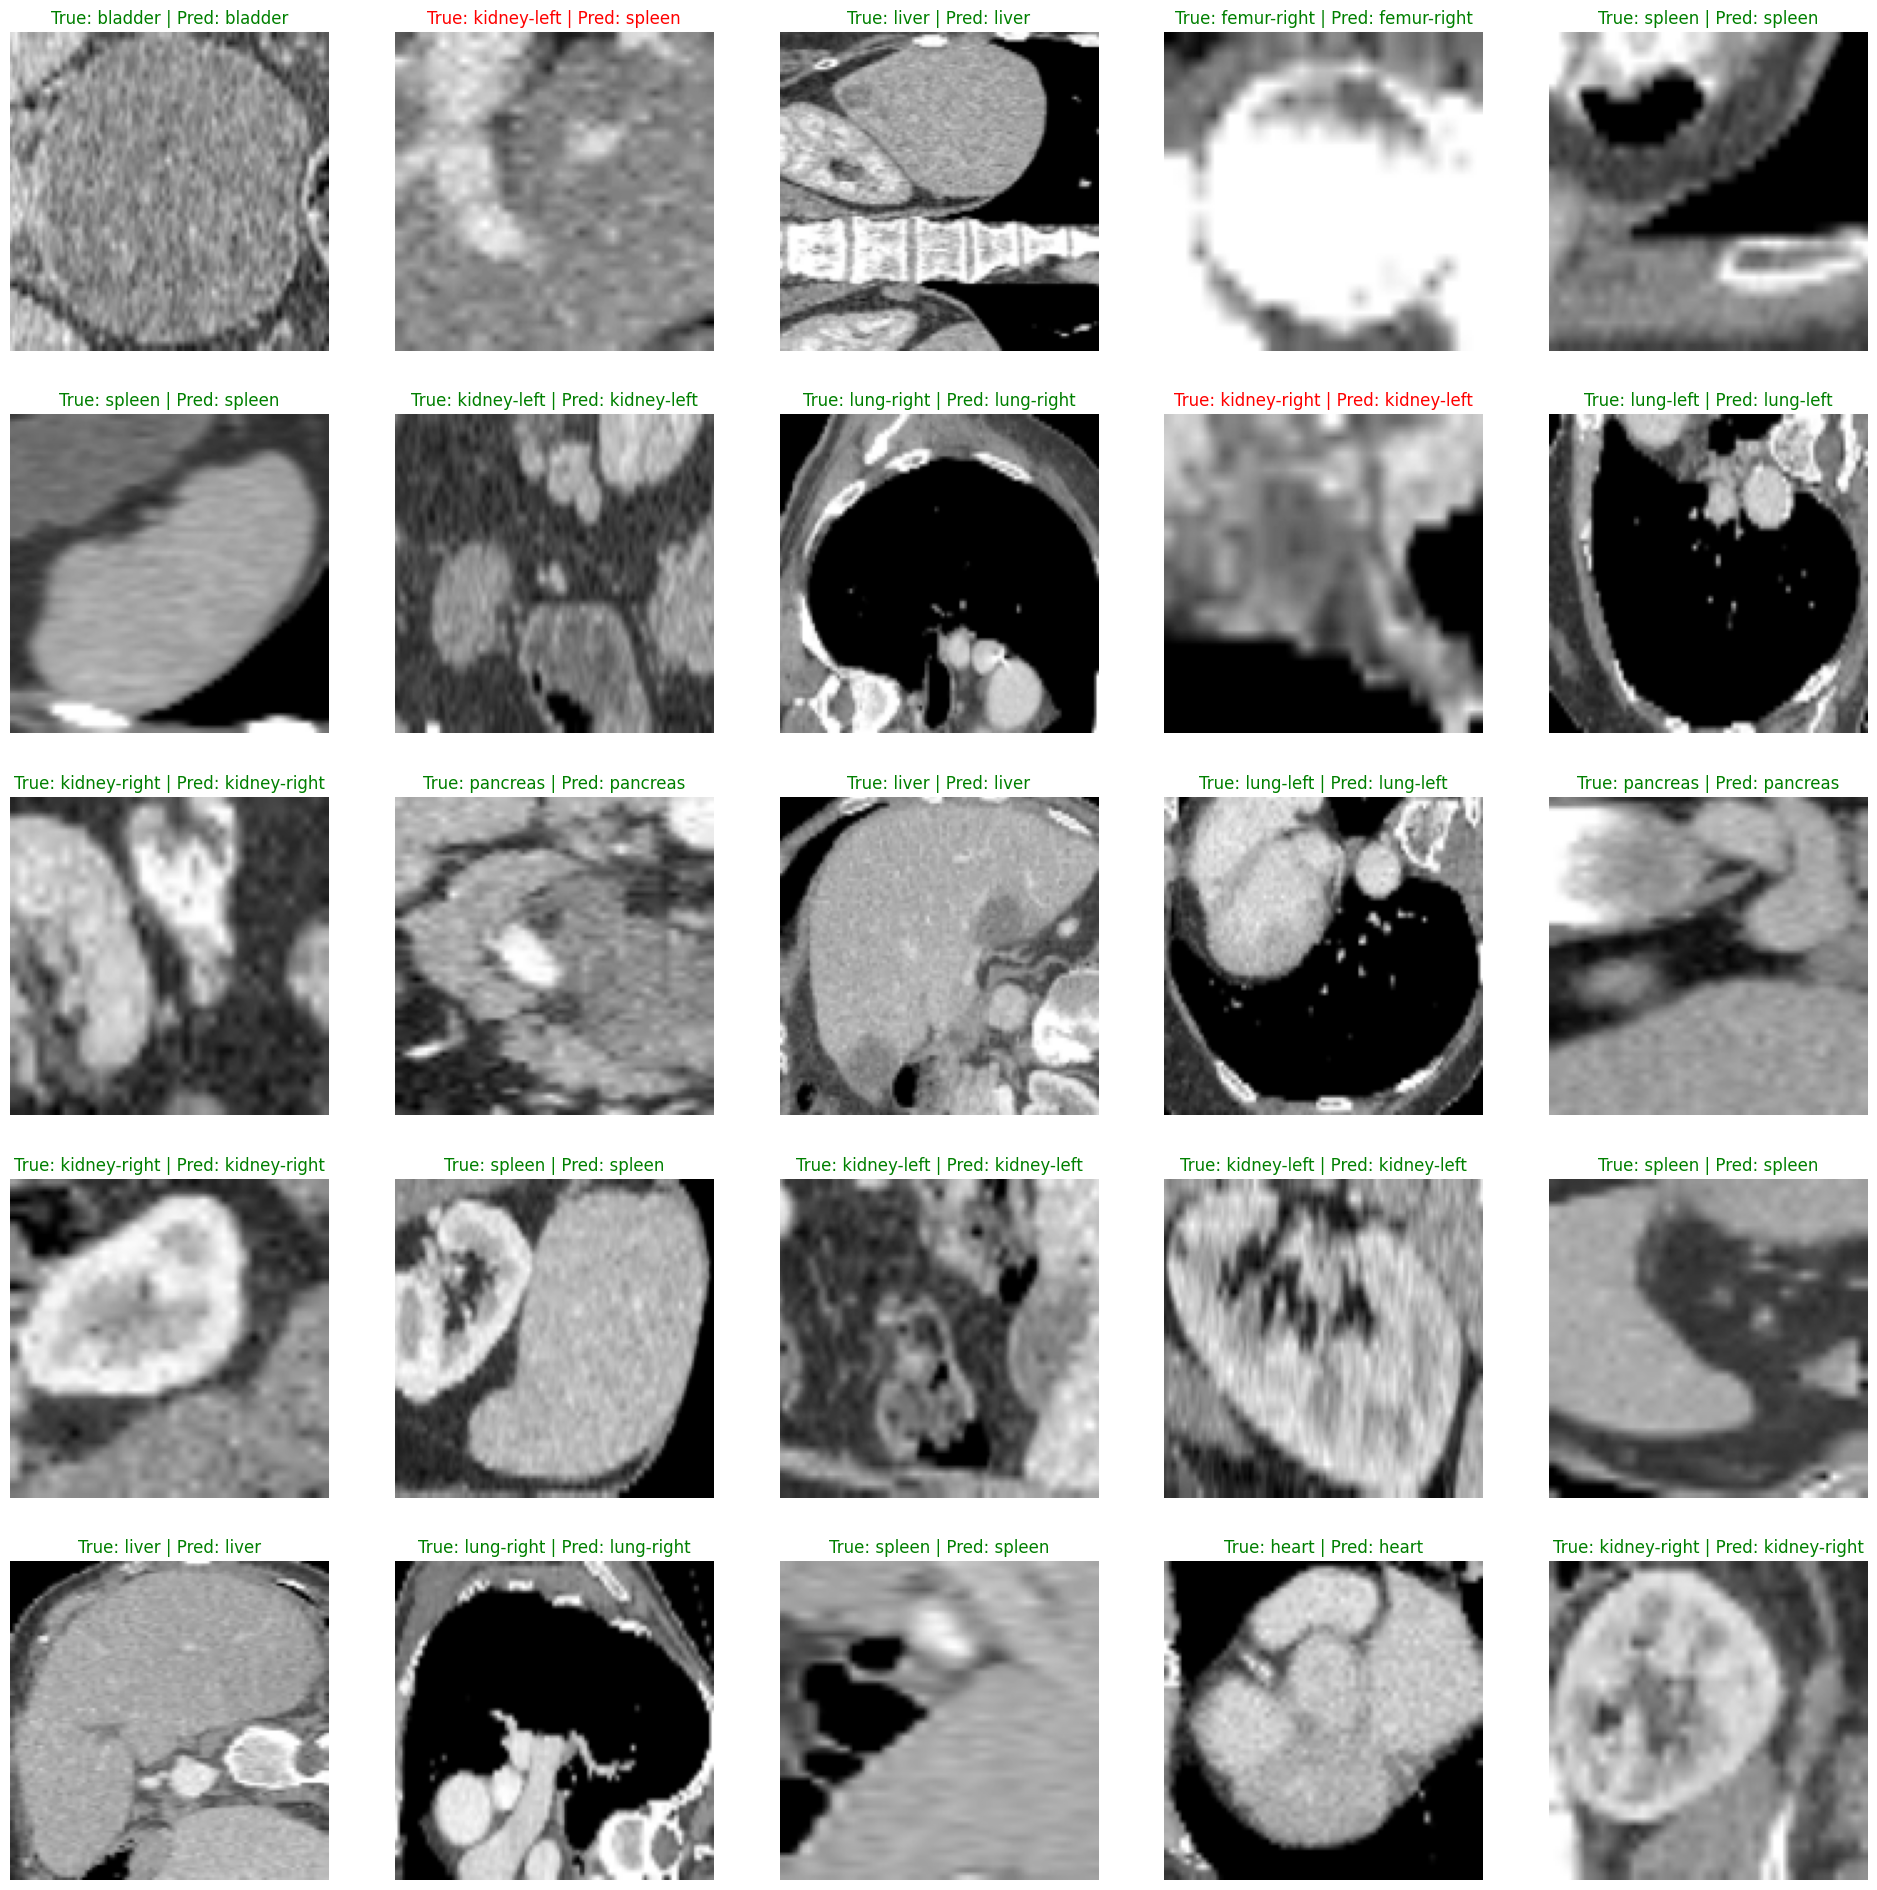

In [208]:
fig, axes = plt.subplots(5, 5, figsize=(24, 24))
for img, true_label, pred, ax in zip(images, val_labels, val_preds, axes.flatten()):
    ax.imshow(img.view(128, 128).cpu(), cmap='gray')
    font = {"color": "r"} if true_label != pred else {"color": "g"}
    true_label, pred = idx_to_label[true_label.item()], idx_to_label[pred]
    ax.set_title(f"True: {true_label} | Pred: {pred}", fontdict=font)
    ax.axis('off')


## Confusion Matrix

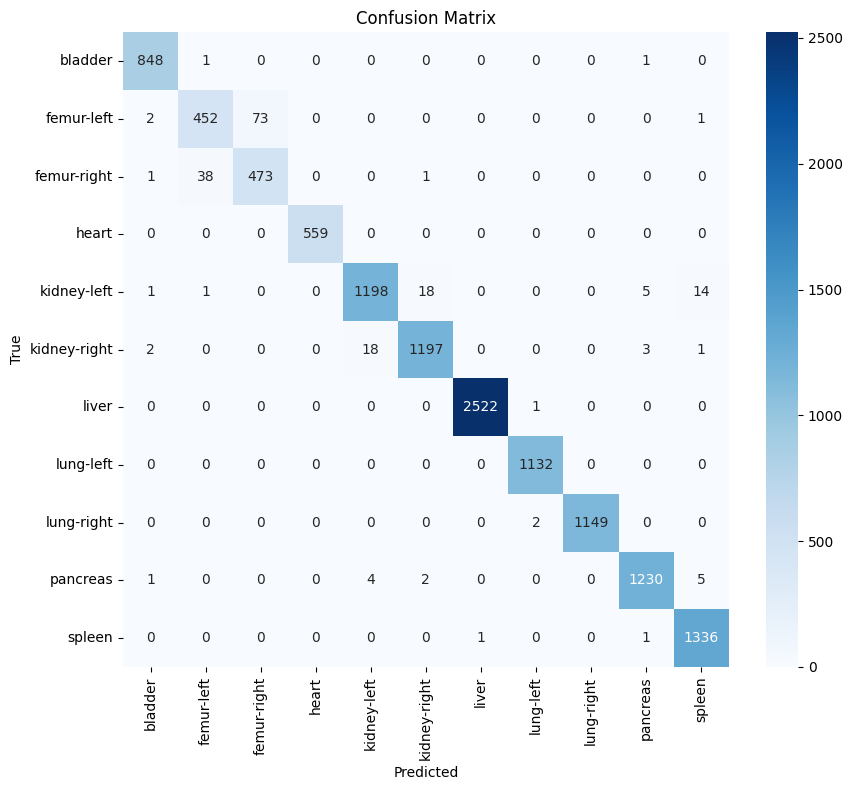

In [209]:
# === Confusion Matrix ===
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(val_labels, val_preds)
labels = list(idx_to_label.values())  

plt.figure(figsize=(9, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig(f'{model_output_dir}/conf_matrix.png')
plt.show()

# Testing

## Load Test Data

In [210]:
test_transform = A.Compose([
    A.Resize(128, 128),
    
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

In [211]:
idx_to_label

{0: 'bladder',
 1: 'femur-left',
 2: 'femur-right',
 3: 'heart',
 4: 'kidney-left',
 5: 'kidney-right',
 6: 'liver',
 7: 'lung-left',
 8: 'lung-right',
 9: 'pancreas',
 10: 'spleen'}

In [212]:
# === Predict on Test Set ===
test_files = os.listdir('test')
test_df = pd.DataFrame({'id': test_files})
test_dataset = BiomedicalDataset(df=test_df, img_dir='test', mode='test', val_test_transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

## Load Best Model

In [213]:
config = torch.load(f'{model_output_dir}/configs.pth', map_location=device, weights_only=False)
config

Config(num_classes=11)

In [214]:
model = ResNet18(num_classes=config.num_classes).to(device)

In [215]:
weights = torch.load(f'{model_output_dir}/weights_best.pth', map_location=device)
model.load_state_dict(weights)

<All keys matched successfully>

## Predict Test

In [216]:
preds = []
model.eval()
with torch.no_grad():
    for images, _, features, filenames in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        features = features.to(device)
        with autocast(device_type="cuda" if torch.cuda.is_available() else "cpu"):
            outputs = model(images, features)
        predicted = torch.argmax(outputs, dim=1).cpu().tolist()
        for fname, pred in zip(filenames, predicted):
            preds.append((fname, idx_to_label[pred]))

Testing: 100%|██████████| 181/181 [00:45<00:00,  3.98it/s]


## Submission

In [217]:
# After collecting preds as a list of (filename, class)
submission_df = pd.DataFrame(preds, columns=['id', 'class'])

# Read the original test.csv to get the correct order
test_csv = pd.read_csv('test.csv')

# Merge to preserve the order of 'id' in test.csv
ordered_submission = test_csv[['id']].merge(submission_df, on='id', how='left')

In [218]:
ordered_submission

,id,class
0,a_0.png,heart
1,a_1.png,liver
2,a_2.png,lung-right
3,a_3.png,liver
4,a_4.png,femur-right
...,...,...
46151,s_8822.png,pancreas
46152,s_8823.png,spleen
46153,s_8824.png,spleen
46154,s_8825.png,lung-left


In [219]:
ordered_submission.to_csv(f"{model_output_dir}/submission_{model_output_dir}.csv", index=False)